In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
from matplotlib.pyplot import imread

In [151]:
from random import shuffle
import cv2
from skimage import exposure

In [3]:
data_dir = 'data'

In [9]:
colnames = ['center_img', 'left_img', 'right_img', 'steering_angle', 'throttle', 'break', 'speed']
driving_log_pd = pd.read_csv('%s/driving_log.csv' % data_dir, sep='\t', 
                            names=colnames)
driving_log_pd.head()

,center_img,left_img,right_img,steering_angle,throttle,break,speed
0,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.0,0.0,0,6.427726e-06
1,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.0,0.0,0,4.673742e-07
2,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.0,0.0,0,2.771526e-06
3,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.0,0.0,0,1.514666e-06
4,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.0,0.0,0,1.220517e-05


In [10]:
def parse_file_name(full_path):
    if '/' in full_path:
        return full_path.split('/')[-1]
    else:
        return full_path

In [15]:
for colname in ['center_img', 'left_img', 'right_img']:
    driving_log_pd[colname] = [parse_file_name(x) for x in driving_log_pd[colname].tolist()]

driving_log_pd.head()

,center_img,left_img,right_img,steering_angle,throttle,break,speed
0,center_2018_01_21_10_24_25_576.jpg,left_2018_01_21_10_24_25_576.jpg,right_2018_01_21_10_24_25_576.jpg,0.0,0.0,0,6.427726e-06
1,center_2018_01_21_10_24_25_666.jpg,left_2018_01_21_10_24_25_666.jpg,right_2018_01_21_10_24_25_666.jpg,0.0,0.0,0,4.673742e-07
2,center_2018_01_21_10_24_25_765.jpg,left_2018_01_21_10_24_25_765.jpg,right_2018_01_21_10_24_25_765.jpg,0.0,0.0,0,2.771526e-06
3,center_2018_01_21_10_24_25_847.jpg,left_2018_01_21_10_24_25_847.jpg,right_2018_01_21_10_24_25_847.jpg,0.0,0.0,0,1.514666e-06
4,center_2018_01_21_10_24_25_947.jpg,left_2018_01_21_10_24_25_947.jpg,right_2018_01_21_10_24_25_947.jpg,0.0,0.0,0,1.220517e-05


In [32]:
def display_images(X, start_idx=0, end_idx=None, 
                       columns = 5, use_gray=False, apply_fnc=None):
    if end_idx is None:
        end_idx = X.shape[0]
        
    if apply_fnc is None:
        apply_fnc = lambda image: image
        
    plt.figure(figsize=(32,18))

    num_of_images = end_idx - start_idx
    rows = num_of_images / columns + 1
    
    for i in range(start_idx, end_idx):
        image = X[i]
        
        _i = i % num_of_images
        plt.subplot(rows, columns, _i + 1)
        
        if use_gray:
            plt.imshow(apply_fnc(image), cmap="gray")
        else:
            plt.imshow(apply_fnc(image)) 
            
    plt.tight_layout()
            
    plt.show()

In [17]:
img_dir = '%s/IMG' % data_dir

In [19]:
def read_imgs(img_dir, file_names):
    img_arr = []
    
    for file_name in file_names:
        img = imread('%s/%s' % (img_dir, file_name))
        img_arr.append(img)
        
    return np.stack(img_arr)

In [29]:
sample_imgs = read_imgs(img_dir, driving_log_pd['center_img'].tolist()[:10])
sample_imgs.shape

(10, 160, 320, 3)

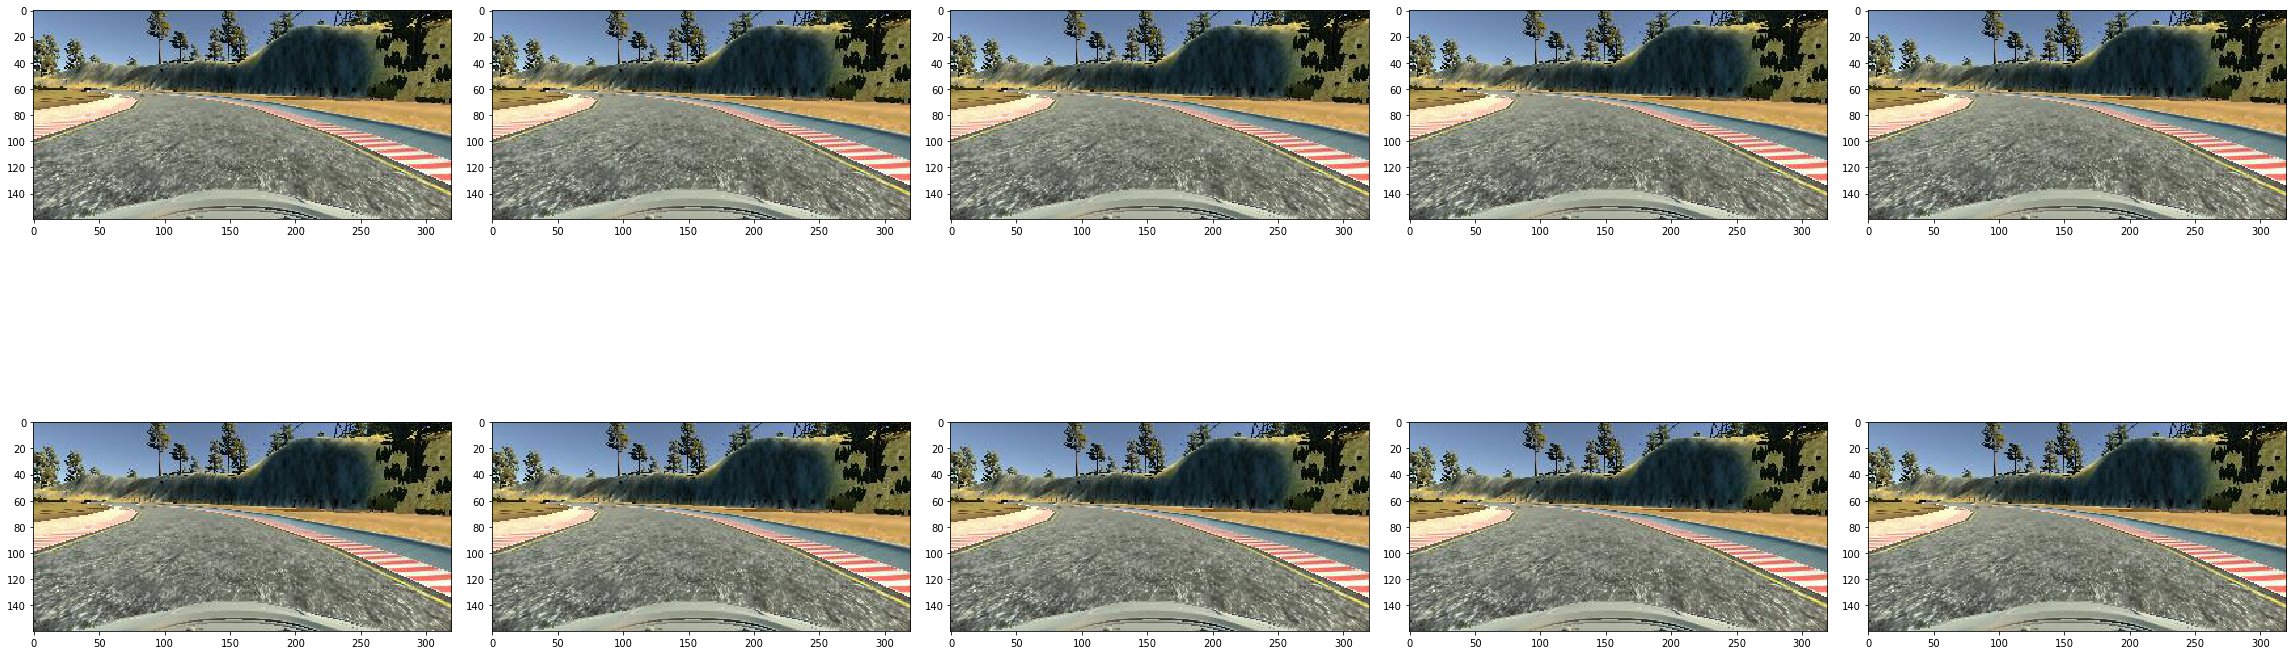

In [35]:
display_images(sample_imgs, columns=5)

In [146]:
def apply_histogram_equalization(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    equalized_image = exposure.equalize_adapthist(gray_image)
    
    return (255.0*equalized_image).astype(np.uint8)

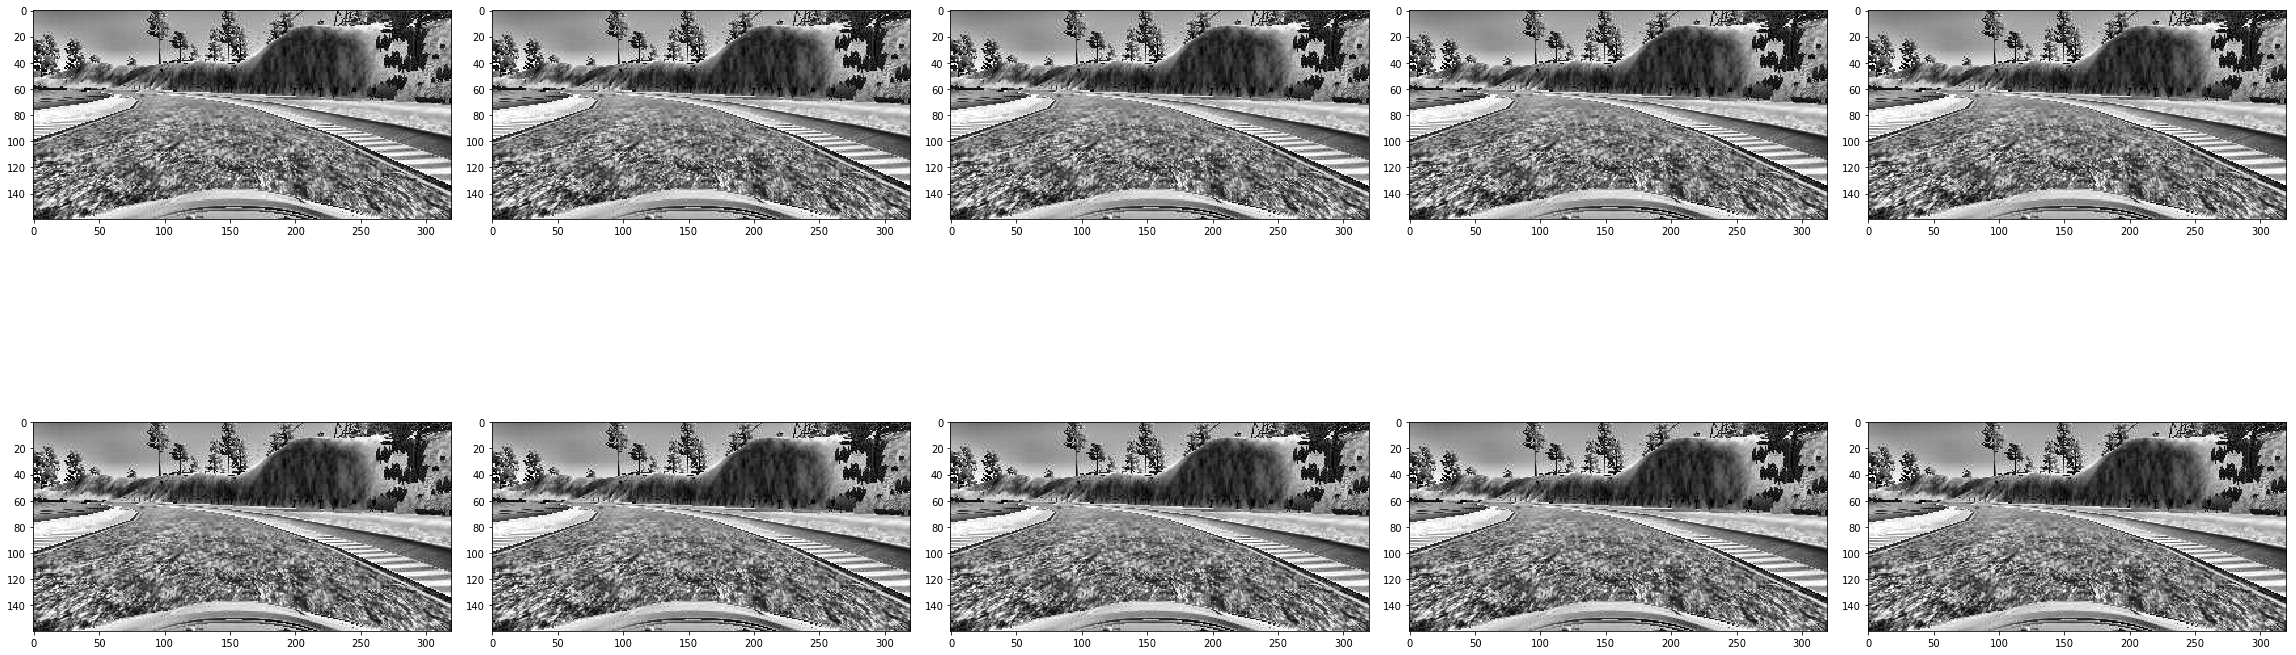

In [153]:
display_images(sample_imgs, columns=5, use_gray=True,
               apply_fnc=apply_histogram_equalization)

## Steering Angles

In [38]:
steering_angles = driving_log_pd['steering_angle'].tolist()

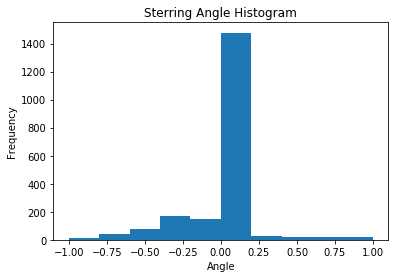

# of bins: 11


In [44]:
n, bins, patches = plt.hist(steering_angles)
plt.title("Sterring Angle Histogram")
plt.xlabel("Angle")
plt.ylabel("Frequency")
plt.show()

print("# of bins: %d" % len(bins))

In [41]:
min(steering_angles), max(steering_angles)

(-1.0, 1.0)

In [49]:
print('minimum frequency: %d' % np.histogram(steering_angles, bins)[0].min())

minimum frequency: 12


## Data

In [82]:
img_steering_pd = driving_log_pd[['center_img', 'steering_angle']]

In [105]:
def split_train_test(img_steering_pd, train_perc=0.7, val_perc=0.2):
    idx_len = len(img_steering_pd.index)
    idxs = list(range(idx_len))
    shuffle(idxs)
    
    idx1 = int(idx_len*train_perc)
    idx2 = idx1 + int(idx_len*val_perc)
    
    train_pd = img_steering_pd.loc[idxs[:idx1]]
    val_pd = img_steering_pd.loc[idxs[idx1:idx2]]
    test_pd = img_steering_pd.loc[idxs[idx2:]]
    
    return train_pd, val_pd, test_pd

In [106]:
train_pd, val_pd, test_pd = split_train_test(img_steering_pd)
print(len(train_pd.index), len(val_pd.index), len(test_pd.index))

1414 404 202


In [120]:
#_train_pd = train_pd.iloc[:int(0.3*len(train_pd.index))]
_train_pd = train_pd
_val_pd = val_pd.iloc[:100]
_test_pd = test_pd.iloc[:100]

In [121]:
X_train = read_imgs(img_dir, _train_pd['center_img'].tolist())
y_train = np.array(_train_pd['steering_angle'])
X_val = read_imgs(img_dir, _val_pd['center_img'].tolist())
y_val = np.array(_val_pd['steering_angle'])
X_test = read_imgs(img_dir, _test_pd['center_img'].tolist())
y_test = np.array(_test_pd['steering_angle'])

In [126]:
X_train.shape

(1414, 160, 320, 3)

## Model

In [160]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.optimizers import Adam

In [192]:
from keras import backend as K

In [200]:
dir(K.tf.image)

['ResizeMethod',
 '_Check3DImage',
 '_ImageDimensions',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_allowed_symbols',
 'adjust_brightness',
 'adjust_contrast',
 'adjust_gamma',
 'adjust_hue',
 'adjust_saturation',
 'central_crop',
 'convert_image_dtype',
 'crop_and_resize',
 'crop_to_bounding_box',
 'decode_gif',
 'decode_jpeg',
 'decode_png',
 'draw_bounding_boxes',
 'encode_jpeg',
 'encode_png',
 'extract_glimpse',
 'flip_left_right',
 'flip_up_down',
 'grayscale_to_rgb',
 'hsv_to_rgb',
 'non_max_suppression',
 'pad_to_bounding_box',
 'per_image_standardization',
 'random_brightness',
 'random_contrast',
 'random_flip_left_right',
 'random_flip_up_down',
 'random_hue',
 'random_saturation',
 'resize_area',
 'resize_bicubic',
 'resize_bilinear',
 'resize_image_with_crop_or_pad',
 'resize_images',
 'resize_nearest_neighbor',
 'rgb_to_grayscale',
 'rgb_to_hsv',
 'rot90',
 'sample_distorted_bounding_box',
 'transpos

In [169]:
def apply_histogram_equalization_to_images(images, n):
    image_arr = []
    
    for i in range(n):
        image_arr.append(apply_histogram_equalization(images[i]))
        
    return np.stack(image_arr)

In [170]:
batch_size=32

In [175]:
import tensorflow as tf
tf.__version__

'0.12.1'

In [179]:
def rgb_to_grayscale(x):
    import tensorflow as tf
    
    return tf.image.rgb_to_grayscale(x)

In [201]:
model = Sequential()
model.add(Lambda(lambda x: K.tf.image.rgb_to_grayscale(x), input_shape=(160,320,3)))

model.add(Lambda(lambda x: x / 255.0 - 0.5))
model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))

In [202]:
lr=0.0001
nb_epoch=10

optimizer = Adam(lr=lr)
model.compile(loss='mse', optimizer=optimizer)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size,
          shuffle=True, nb_epoch=nb_epoch)

Train on 1414 samples, validate on 100 samples
Epoch 1/10
1414/1414 [==============================] - 8s - loss: 0.0830 - val_loss: 0.0842

In [203]:
test_loss = model.evaluate(X_test, y_test)
test_loss

100/100 [==============================] - 0s     


0.065603616423904901

In [204]:
model.save('%s/model.h5'%data_dir)